# Medical Cost Prediction

&emsp;This guided project with [Dataquest](https://app.dataquest.io/c/136/m/730/guided-project%3A-predicting-insurance-costs/1/introduction) aims to practise building a linear regression model for medical cost predictions using information of the patients. This practice can be useful in real situations for hospitals to accurately plan and predict medical cost. The dataset is available from [Miri Choi's Kaggle page](https://www.kaggle.com/datasets/mirichoi0218/insurance/data).

1. [Data Exploration](#explore)
2. [Clustering](#cluster)
3. [Model Training](#train)
4. [Model Interpretation](#interpret)
5. [Model Evaluation](#evaluate)

In [711]:
# Import libraries
# data manipulations
import pandas as pd
import numpy as np
# visualization tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.style.use('fivethirtyeight')
%matplotlib inline
# clustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
# model building & evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Data Exploration<a id='explore'></a>

In [712]:
# Import data
df = pd.read_csv("insurance.csv")
print("Feature data types:")
print(df.dtypes)
df.head(3)

Feature data types:
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [713]:
# Check for missing data
print("Number of missing value:", df.isna().sum().sum())

Number of missing value: 0


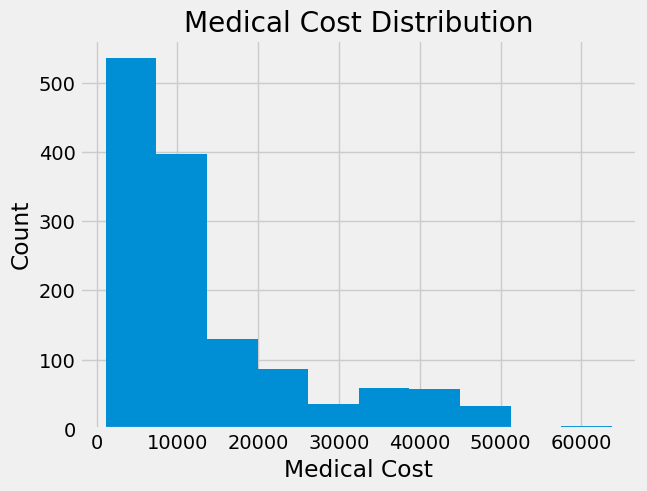

In [714]:
# Check response variable - charges
df['charges'].hist()
plt.title("Medical Cost Distribution")
plt.xlabel("Medical Cost")
plt.ylabel("Count")
plt.show()

&emsp;The distribution of medical cost is positively skewed. A logarithm transformation would be able to make errors in the model more centered around zero (Dataquest accessed Jun 2024).

In [715]:
df['log_y'] = np.log2(df['charges'])

In [716]:
# Check values for each categorical feature
for feature in df.select_dtypes(include=object).columns:
    print(df[feature].value_counts().sort_index())
    print()

sex
female    662
male      676
Name: count, dtype: int64

smoker
no     1064
yes     274
Name: count, dtype: int64

region
northeast    324
northwest    325
southeast    364
southwest    325
Name: count, dtype: int64



* The dataset contains no missing values.  
* There are 3 categorical features as shown above.
    * If categorical values are found to be useful for modelling, they will be converted into dummies variables.  

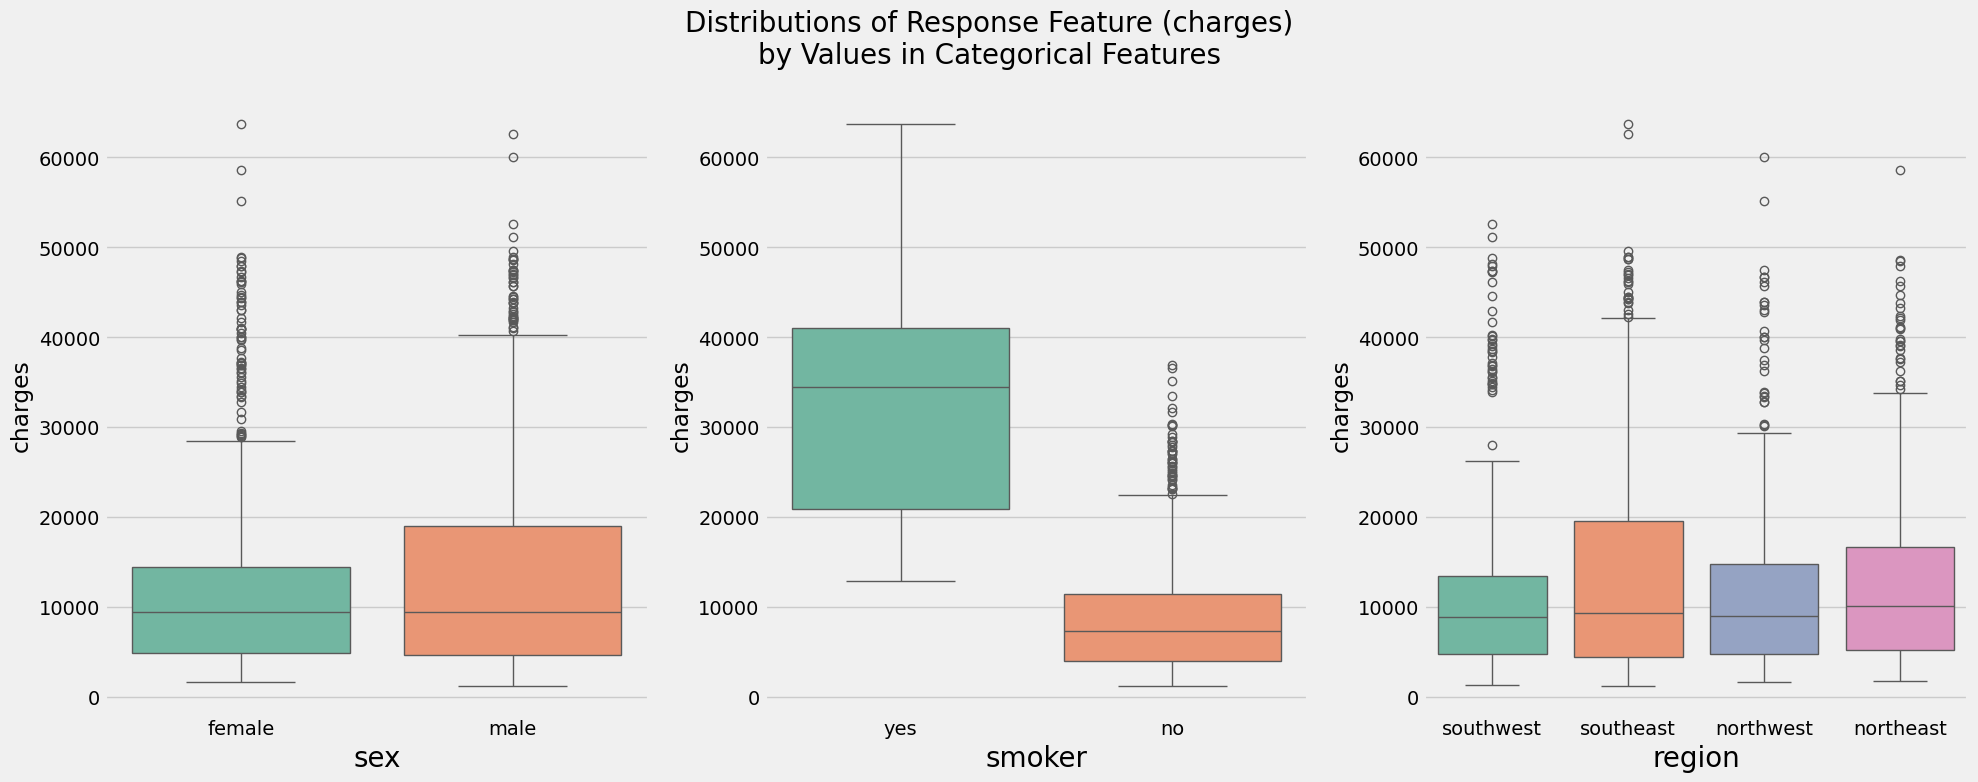

In [717]:
# Boxplots for categorical features
fig = plt.figure(figsize=(20,8))
for i, feature in enumerate(df.select_dtypes(include=object).columns):
    ax = fig.add_subplot(1, 3, i+1)
    sns.boxplot(df, x=feature, y='charges', hue=feature, palette=sns.color_palette('Set2', n_colors=len(df[feature].value_counts().index)), ax=ax)
    ax.set_xlabel(feature, fontsize=20)
fig.suptitle("Distributions of Response Feature (charges)\nby Values in Categorical Features", fontsize=20)
fig.tight_layout()
plt.show()

&emsp;Simply looking at the distributions from the boxplots, there is a clear difference in the distributions of medical costs between smokers and non-smokers. Thus, **smoker** seems to be a promising feature for the training the model. Apart from this apparent difference, people who are males in **sex** and in southeast in **region** seems to have higher medical costs. Consequently, **sex** and the dummy variable **southeast of region** can be considered in the early stage of modelling.

In [718]:
# Convert categorical features as dummy variables
df_dummies = pd.get_dummies(df, dtype=int)
# Rearrange response variable to the last column
#   - looks tedious here :-)
y = df_dummies[['charges','log_y']]
df_dummies = df_dummies.drop(columns=['charges','log_y'])
df_dummies = pd.concat([df_dummies, y], axis=1)
df_dummies.head(2)

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,charges,log_y
0,19,27.90,0,1,0,0,1,0,0,0,1,16884.9240,14.043448
1,18,33.77,1,0,1,1,0,0,0,1,0,1725.5523,10.752842


&emsp;After converting categorical features into numbers, correlation among features including response variable is shown to confirm above observation as well as to reveal response variable's relationship with the numeric features.

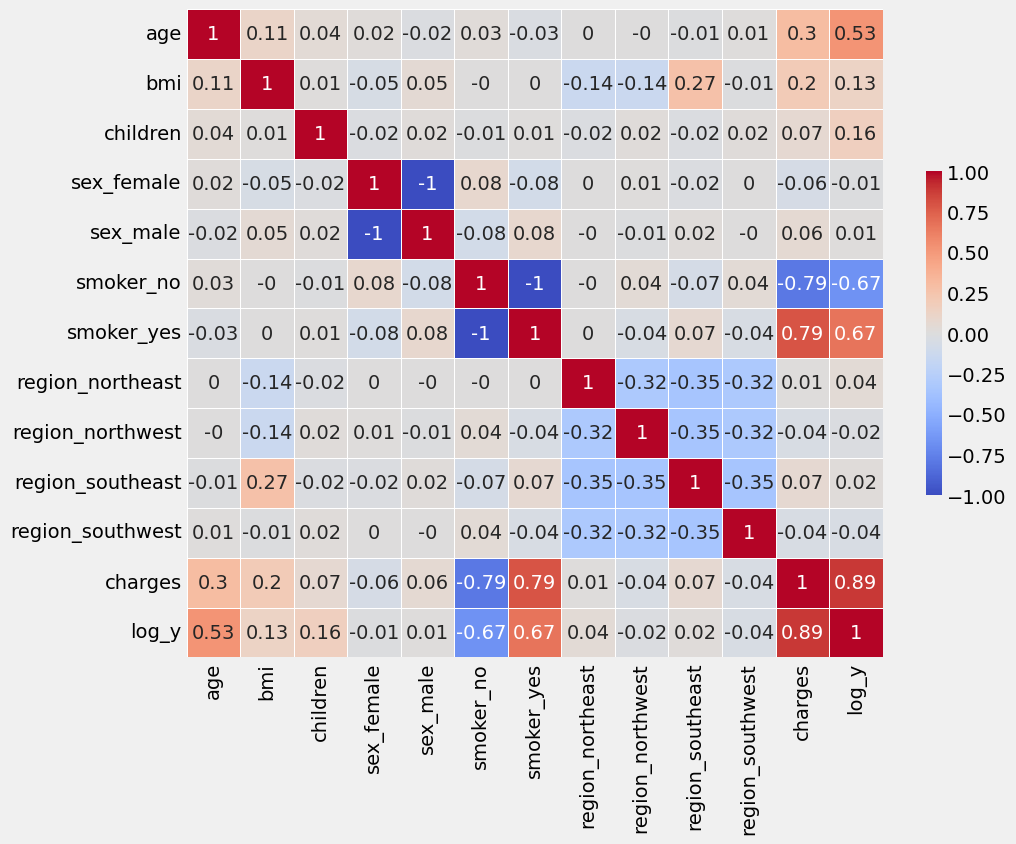

In [719]:
cor = round(df_dummies.corr(), 2)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cor, cmap='coolwarm', annot=True, vmin=-1, vmax=1, center=0, linewidths=.5, cbar_kws={"shrink": .5})
ax.grid(False)
plt.show()

&emsp;By looking at the last row of the plot, number of children, sex, and region indicate insignificant relationship with the response variable, medical cost. The most significant pearson coefficients are shown in both the **smoker** dummy variables. One of them will be used to train the model. **Age** and **bmi** will also be considered in the process as they showed some correlation with the response variable. Further visualization will be done to examine and confirm the significance of the linear relationship.

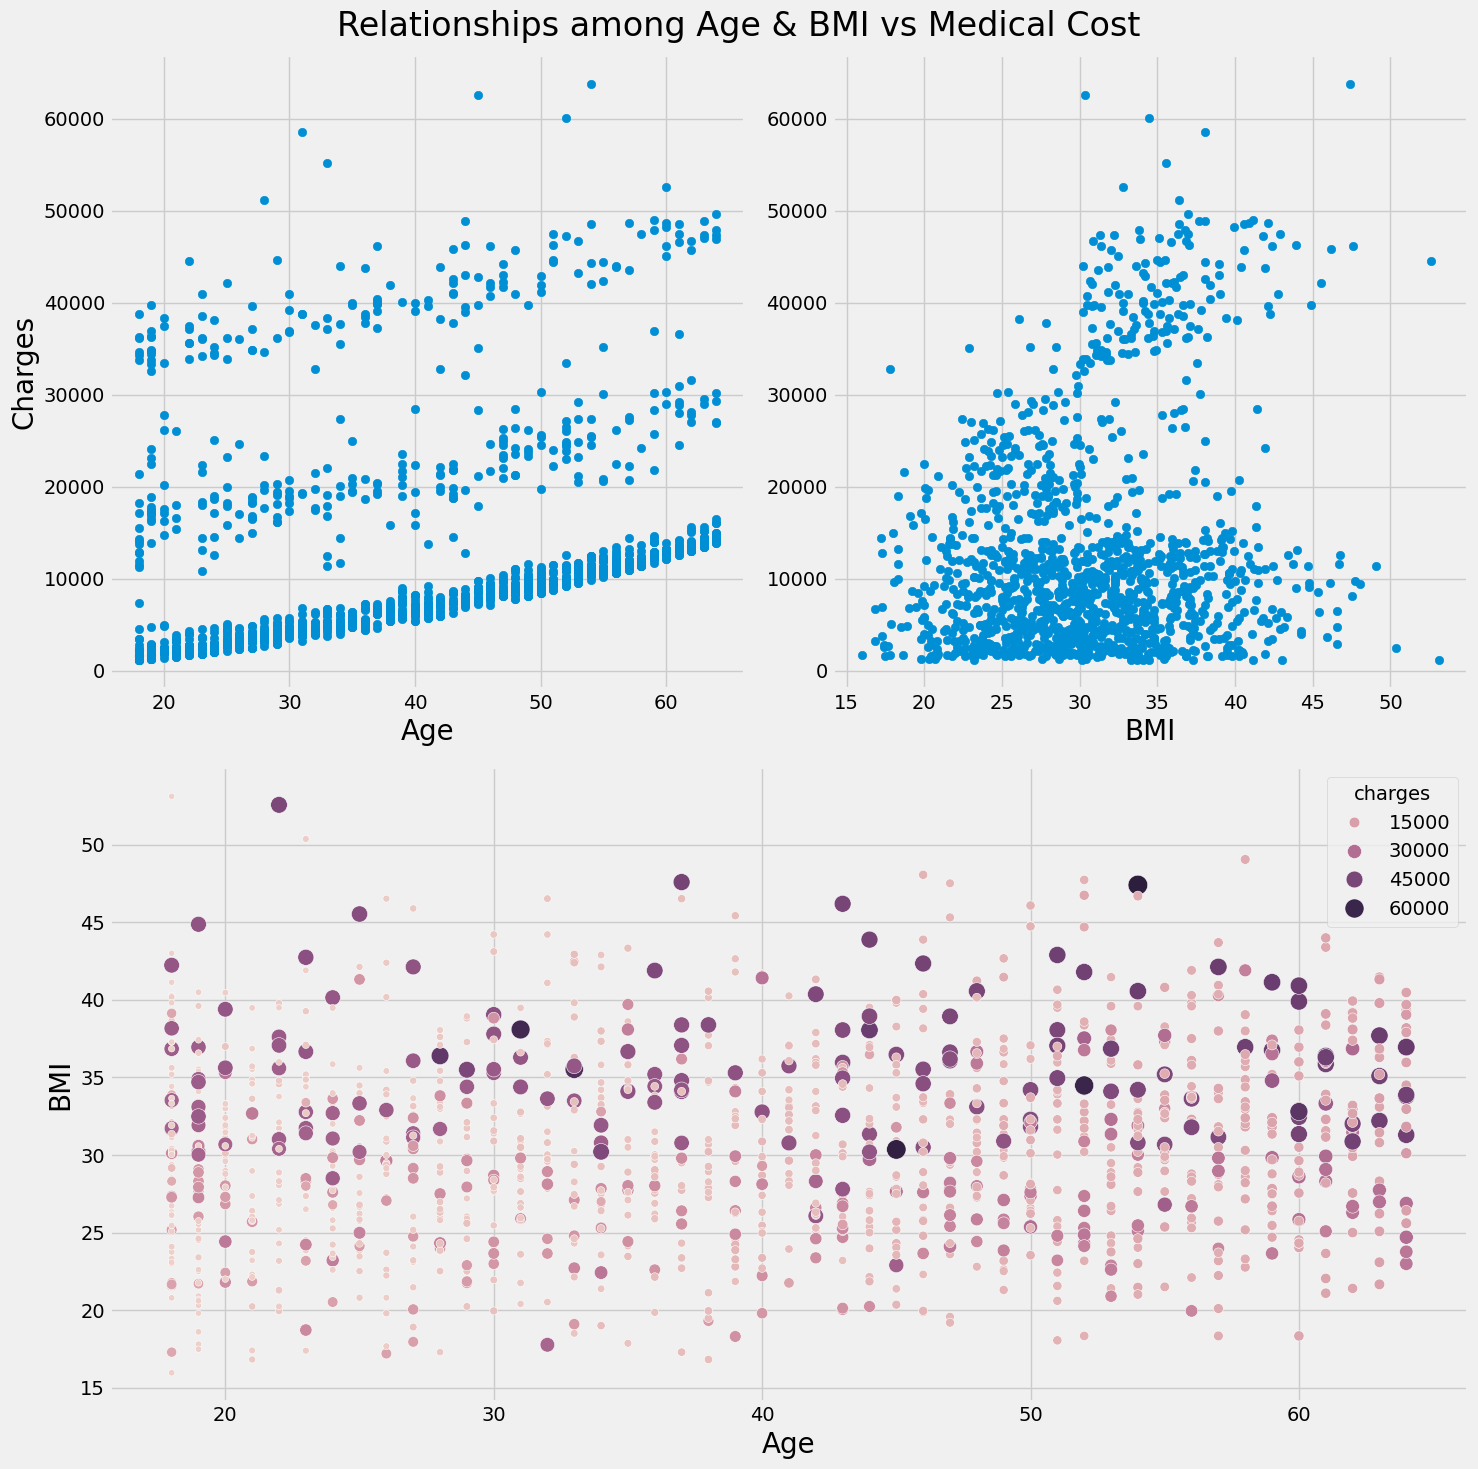

In [720]:
# Scatterplots for age and bmi versus charges
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(2,2,1)
ax1.scatter(data=df_dummies, x='age', y='charges')
ax1.set_xlabel('Age', fontsize=20)
ax1.set_ylabel('Charges', fontsize=20)

ax2 = fig.add_subplot(2,2,2)
ax2.scatter(data=df_dummies, x='bmi', y='charges')
ax2.set_xlabel('BMI', fontsize=20)

ax3 = fig.add_subplot(2,1,2)
sns.scatterplot(data=df_dummies, x='age', y='bmi', size='charges', sizes=(20,200), hue='charges', ax=ax3)
ax3.legend(title='charges', loc='best')
ax3.set_xlabel('Age', fontsize=20)
ax3.set_ylabel('BMI', fontsize=20)

fig.suptitle("Relationships among Age & BMI vs Medical Cost", fontsize=24)
fig.tight_layout()
plt.show()

&emsp;Simply looking at the relationships from the scatterplots, **BMI** does not show apparent linear relationship with charges. **Age** shows a positive relationship with charges; however, there is quite a wide variance in charges. Apparently, there are 3 trendlines in the plot. There may be another crucial feature(s) segmenting people into these 3 groups. As a result, before **Age** and **Smoker** are used to train the model, DBSCAN and Gaussian Mixture Model will be used to cluster the people into desirably 3 groups.<a id='charges-age'></a>

# Clustering<a id='cluster'></a>

In [721]:
# Scale features for DBSCAN 
df_dummies['age_sqrt'] = np.sqrt(df_dummies['age'])
scaler = StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(df_dummies[['age','charges']]), columns=[['age','charges']])
# DBSCAN
db = DBSCAN()
clusters_db = db.fit_predict(scaled)
np.unique(clusters_db)

array([-1,  0])

In [722]:
# Gaussian Mixture Modelling 
gm = GaussianMixture(n_components=3)
clusters_gm = gm.fit_predict(df_dummies[['age_sqrt','charges']])
np.unique(clusters_gm)

array([0, 1, 2])

&emsp;DBSCAN and Gaussian Mixture Model (GMM) clustering algorthms were used. DBSCAN auto discovers the number of clusters based on density whereas GMM is a distance based probabilistic model where covariance structure is taken into account (Baruah 2020). The number of clusters, 3, is chosen for GMM clustering based on the [visualization](#charges-age). DBSCSAN, on the other hand, detected 2 clusters. The relationship between **Age** and **Charges** are displayed again with the labels from the clustering algorithms.

In [723]:
df_dummies['db'] = clusters_db + 1
df_dummies['gm'] = clusters_gm

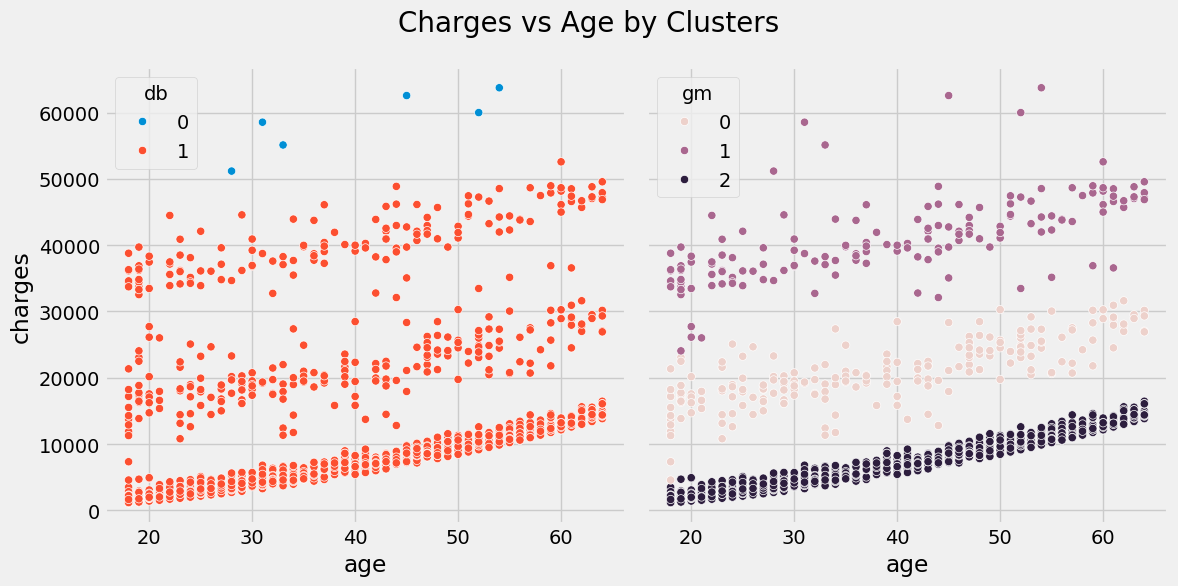

In [724]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1,2,1)
sns.scatterplot(x="age", y="charges", hue="db", data=df_dummies, ax=ax1)

ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(x="age", y="charges", hue="gm", data=df_dummies, ax=ax2)
ax2.set_ylabel("")
ax2.set_yticklabels([])

fig.suptitle("Charges vs Age by Clusters", fontsize=20)
fig.tight_layout()
plt.show()

&emsp;DBSCAN, in this case, was only able to separate the scattered outliers from the three main trendlines. On the other hand, the GMM algorithm managed to label the data points from the trendlines into 3 clusters. Thus, the labels from GMM will be used for model training. Before training, the labels are conveted into dummy variables due to their nominal characteristic.

In [725]:
df_dummies.drop(columns=['db'], inplace=True)
df_dummies = pd.get_dummies(df_dummies, columns=['gm'], dtype=int)
df_dummies.head(2)

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,charges,log_y,age_sqrt,gm_0,gm_1,gm_2
0,19,27.90,0,1,0,0,1,0,0,0,1,16884.9240,14.043448,4.358899,1,0,0
1,18,33.77,1,0,1,1,0,0,0,1,0,1725.5523,10.752842,4.242641,0,0,1


# Model Training<a id='train'></a>

In [726]:
# Predictors and response variable
X = df_dummies.drop(columns='charges')
y = df_dummies['charges']
# Training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=4)

In [727]:
# Fitting training data
lm = LinearRegression()
lm.fit(X_train[['smoker_yes','age','gm_0','gm_1','gm_2']], y_train)
train_pred = lm.predict(X_train[['smoker_yes','age','gm_0', 'gm_1', 'gm_2']])
print('Intercept =', lm.intercept_)
print('Coefficient =', lm.coef_)
print('Root mean squared error =', mean_squared_error(y_train, train_pred, squared=False))
print('R squared =', r2_score(y_train, train_pred))

Intercept = 11563.131090414936
Coefficient = [  1387.91108775    273.81382123  -2079.81834288  17359.95457498
 -15280.1362321 ]
Root mean squared error = 2205.2689824852664
R squared = 0.9677356216230408


/Users/moswai/Documents/Mos/.venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


&emsp;The root mean squared error of this preliminary model is 6328.57. Next, plotting a residual plot would testify the linearity assumption.

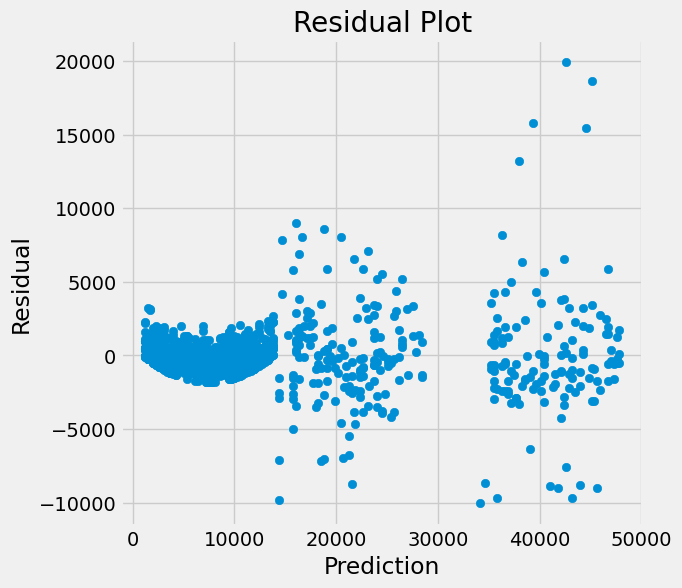

In [728]:
residuals = y_train - train_pred
plt.figure(figsize=(6,6))
plt.scatter(train_pred, residuals)
plt.xlabel("Prediction")
plt.ylabel("Residual")
plt.title("Residual Plot")
plt.show()

&emsp;The residual plot gives a strange distribution of values. The gap may be caused by the strong effect of the categorical feature **Smoker**. Residuals are denser in some part and scattered in others which could be the hidden but important feature(s) explaining the separated trendlines in the **Age** scatterplot previously. Other than these, the residuals seem to remain in a constant band.

# Model Interpretation<a id='interpret'></a>

&emsp;The model is expressed as
$$
Charges = -2393.65 + 24667.06(Smoker) + 275.50(Age)
$$
The intercept is a negative value which, in this case, is meaningless. Regardless of age, being a **Smoker** alone increases the predicted medical cost by 24667.06. As for **Age**, the predicted medical cost increases when **Age** increases by 1 year. However for this particular model, a prediction for a non-smoker person under the age of approximately 9 yields a negative value. As a result, this model is not applicable to people under these characteristics.

# Model Evaluation<a id='evaluate'></a>

In [729]:
# Evaluate with test data
test_pred = lm.predict(X_test[['smoker_yes','age']])
print('Root mean squared error =', mean_squared_error(y_test, test_pred, squared=False))
print('R squared =', r2_score(y_test, test_pred))
plt.scatter(test_pred, y_test, alpha=.5)
plt.plot([0,y_test.max()],[0,y_test.max()], lw=1, color='red', alpha=.5)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Actual vs Predicted Values")
plt.show()

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- gm_0
- gm_1
- gm_2


&emsp;The root mean squared error slightly increases when the prediction is carried out on test data. The coefficient of determination ($R^2$) decreases from .73 to .65 which means the model can only explains 65% of the variance of medical costs. The model is yet to be a reliable tool for predicting medical cost.  

&emsp;As shown in the Actual vs Predicted Values plot, the model seems to be able to accurately predict values in the low range of medical cost. This could be explained by sampling error which its sign is also shown and partially explained in the [scatterplot](#charges-age) previously which shows 3 separated trendlines. The bottom trendline is much denser than other two. Although all the trendlines gradually go up with age, the amount of medical cost differs. The potential reason to this could be explained by wealth of the people or their choices of medical expenditure allocation. Private hospital usually charges much more than the public hospitals. The trendlines could be explained by the type of hospital or services the people choose to receive.

# References
Baruah, Indraneel Dutta 2020. "K-means, DBSCAN, GMM, Agglomerative clustering — Mastering the Popular Models in a Segmentation Problem." Towards Data Science. https://towardsdatascience.com/k-means-dbscan-gmm-agglomerative-clustering-mastering-the-popular-models-in-a-segmentation-c891a3818e29.  

Dataquest accessed Jun 2024. "Outcome Transformations." Dataquest. https://app.dataquest.io/c/136/m/729/applying-linear-regression-models/5/outcome-transformations?path=2&slug=data-scientist&version=2.5. 